<a href="https://colab.research.google.com/github/Tawheed-tariq/Machine-learning-course/blob/main/simple%20projects/malaria%20diagnosis/malaria_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, FalsePositives, FalseNegatives, TrueNegatives, TruePositives, Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.models import Model
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns


In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files= True, split = ['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset , val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

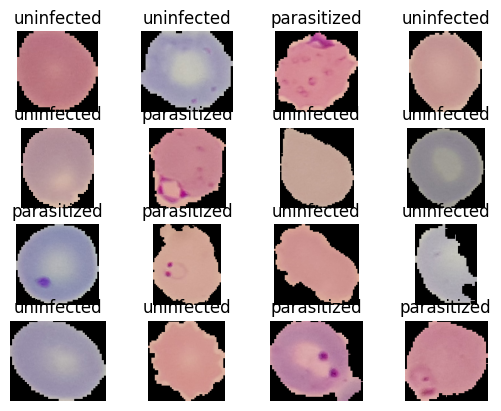

In [6]:
for i , (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data preprocessing

In [7]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/ 255.0, label

In [8]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [9]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model Creation and Training

In [11]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),
    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [12]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = 2, strides = 2)(x)
x = Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model = Model(func_input, output, name = "feature_extractor")
feature_extractor_model.summary()


Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [13]:
feature_extractor_seq = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters = 6, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 3, padding = 'valid', strides = 1, activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
])
feature_extractor_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_6 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_7 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [14]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
# x = feature_extractor_model(func_input)
x = feature_extractor_seq(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


Model: "lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_8 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                       

# Model Subclassing

In [15]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, padding, strides, activation, pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv1 = Conv2D(filters = filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn1 = BatchNormalization()
    self.maxpool1 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv2 = Conv2D(filters = 2*filters , kernel_size = kernel_size, padding = padding, strides = strides, activation = activation)
    self.bn2 = BatchNormalization()
    self.maxpool2 = MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self, x, training):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.maxpool2(x)
    return x

feature_sub_classed = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)


In [16]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = 'Input Image')
x = feature_sub_classed(func_input)

x = Flatten()(x)
x = Dense(100, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation = 'relu')(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation = 'sigmoid')(x)


lenet_model_func = Model(func_input, func_output, name = "lenet_Model")
lenet_model_func.summary()


Model: "lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [17]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()
    self.feature_extractor = FeatureExtractor(8, 3, 'valid', 1, 'relu', 2)

    self.flatten = Flatten()
    self.dense1 = Dense(100, activation = 'relu')

    self.bn1 = BatchNormalization()
    self.dense2 = Dense(10, activation = 'relu')
    self.bn2 = BatchNormalization()

    self.dense3 = Dense(1, activation = 'sigmoid')

  def call(self, x, training):
    x = self.feature_extractor(x)

    x = self.flatten(x)

    x = self.dense1(x)
    x = self.bn1(x)

    x = self.dense2(x)
    x = self.bn2(x)

    x = self.dense3(x)
    return x

lenet_subclassed_model = LenetModel()
lenet_subclassed_model(tf.zeros([1, 224, 224, 3]), training = False)
lenet_subclassed_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_16 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_17 (Ba  multiple                  

In [21]:
metrics = [TruePositives(name= 'tp'), FalsePositives(name = 'fp'), TrueNegatives(name = 'tn'), FalseNegatives(name = 'fn'),
           BinaryAccuracy(name = 'accuracy'), Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

In [22]:
lenet_subclassed_model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = metrics
)

In [23]:
history = lenet_subclassed_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 59s 79ms/step - loss: 0.1673 - tp: 10600.0000 - fp: 708.0000 - tn: 10314.0000 - fn: 424.0000 - accuracy: 0.9487 - precision: 0.9374 - recall: 0.9615 - auc: 0.9784 - val_loss: 0.1644 - val_tp: 1361.0000 - val_fp: 114.0000 - val_tn: 1248.0000 - val_fn: 32.0000 - val_accuracy: 0.9470 - val_precision: 0.9227 - val_recall: 0.9770 - val_auc: 0.9801
Epoch 2/5
689/689 [==============================] - 43s 63ms/step - loss: 0.1521 - tp: 10603.0000 - fp: 651.0000 - tn: 10370.0000 - fn: 422.0000 - accuracy: 0.9513 - precision: 0.9422 - recall: 0.9617 - auc: 0.9826 - val_loss: 0.1770 - val_tp: 1335.0000 - val_fp: 79.0000 - val_tn: 1284.0000 - val_fn: 57.0000 - val_accuracy: 0.9506 - val_precision: 0.9441 - val_recall: 0.9591 - val_auc: 0.9814
Epoch 3/5
689/689 [==============================] - 45s 65ms/step - loss: 0.1320 - tp: 10647.0000 - fp: 590.0000 - tn: 10433.0000 - fn: 376.0000 - accuracy: 0.9562 - precision: 0.9475 - recall: 0.9659 - a

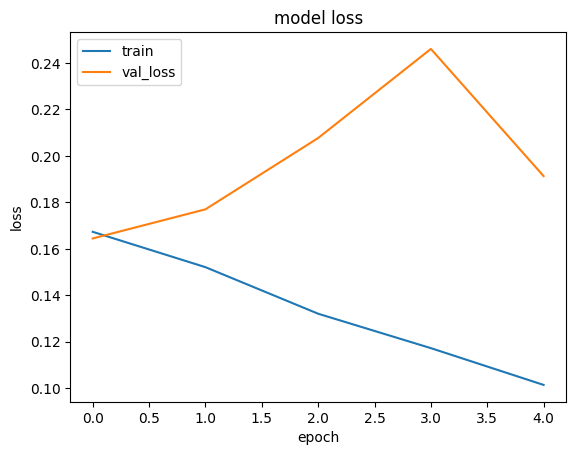

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val_loss'])
plt.show()

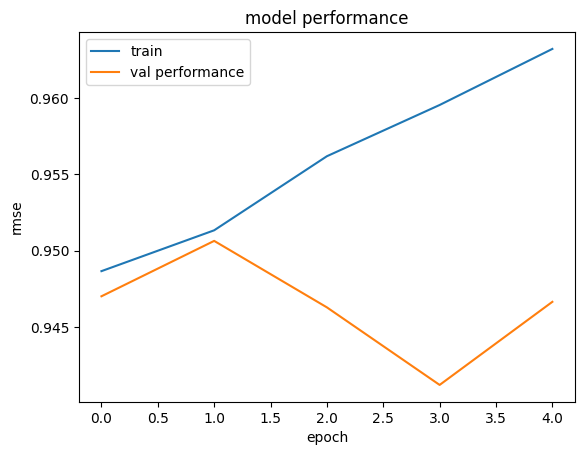

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model performance')
plt.xlabel('epoch')
plt.ylabel('rmse')
plt.legend(['train', 'val performance'])
plt.show()

# Model Evaluation and Testing

In [27]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [28]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
test_dataset = test_dataset.batch(1)

In [30]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
lenet_subclassed_model.evaluate(test_dataset)

2757/2757 [==============================] - 25s 5ms/step - loss: 0.1817 - tp: 1303.0000 - fp: 92.0000 - tn: 1306.0000 - fn: 56.0000 - accuracy: 0.9463 - precision: 0.9341 - recall: 0.9588 - auc: 0.9787


[0.18169230222702026,
 1303.0,
 92.0,
 1306.0,
 56.0,
 0.9463184475898743,
 0.9340502023696899,
 0.9587932229042053,
 0.9787306189537048]

In [34]:
lenet_subclassed_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 11s 11s/step


0.9782769

# Visualizing Confusion matrix

In [45]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)

In [48]:
print(np.array(inp).shape)
print(np.array(inp)[:,0, ...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [46]:
labels = np.array([i[0] for i in labels])

In [47]:
labels

array([1, 0, 1, ..., 0, 1, 1])

In [50]:
predicted = lenet_subclassed_model.predict(np.array(inp)[:,0, ...])
predicted[:, 0]

87/87 [==============================] - 1s 16ms/step


array([0.9782769 , 0.856367  , 0.9953603 , ..., 0.15958567, 0.9990005 ,
       0.9607229 ], dtype=float32)

[[1308   86]
 [  64 1299]]


Text(0.5, 58.7222222222222, 'predicted')

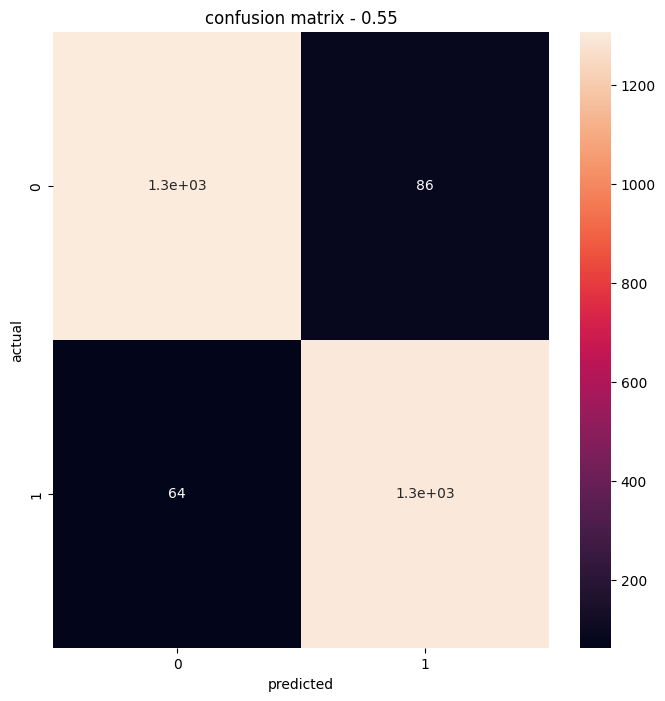

In [72]:
threshold = 0.55

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot=True)
plt.title('confusion matrix - {}'.format(threshold))
plt.ylabel('actual')
plt.xlabel('predicted')


# ROC plot

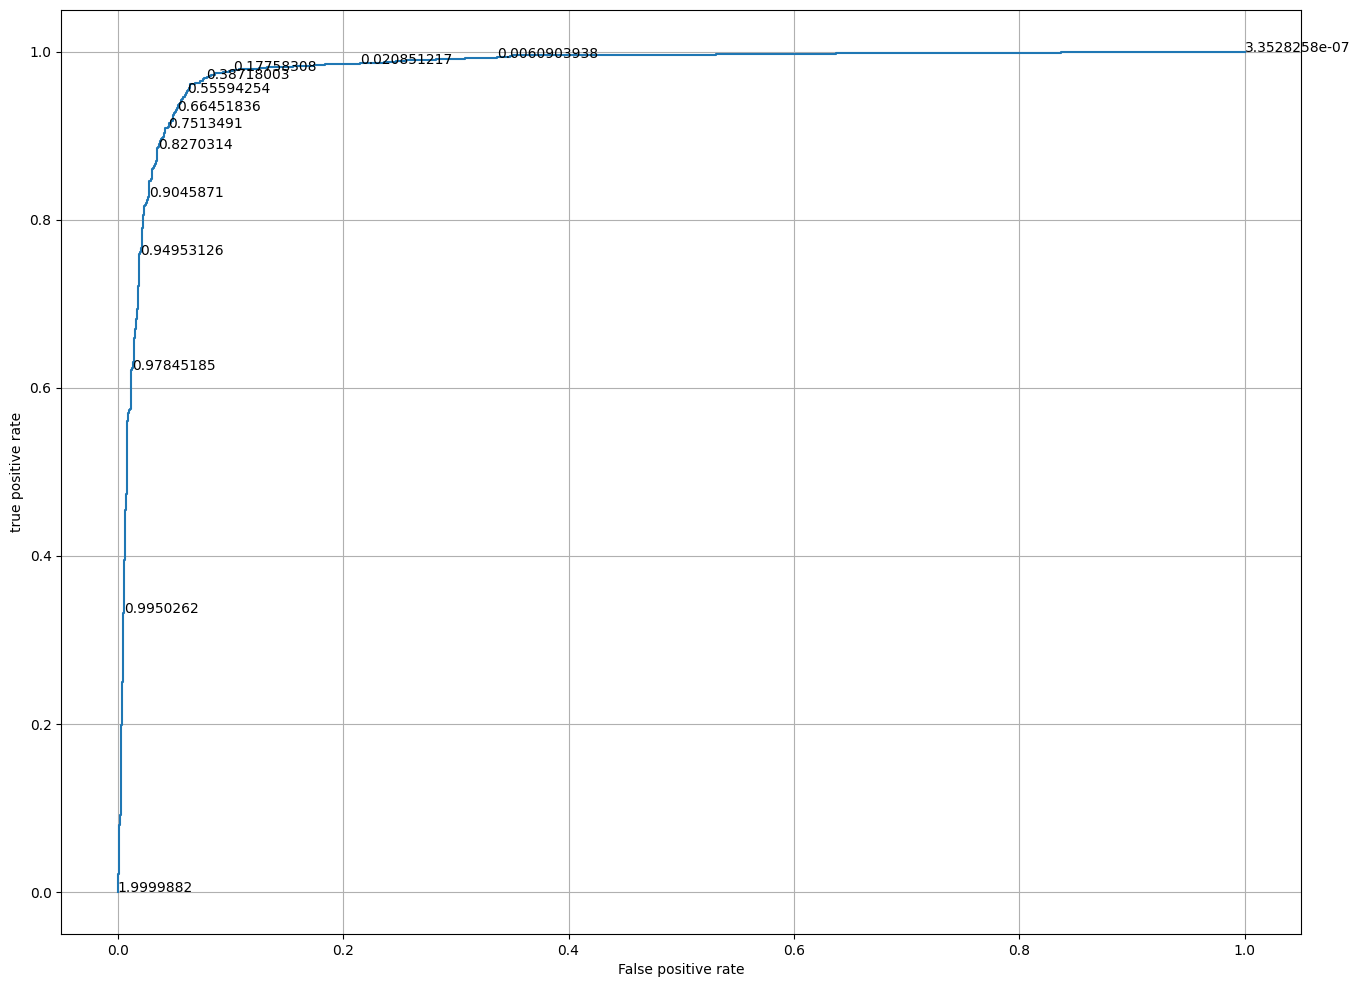

In [68]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.figure(figsize=(16, 12))
plt.plot(fp, tp)
plt.xlabel('False positive rate')
plt.ylabel('true positive rate')
plt.grid()

skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])
plt.show()

In [35]:
def parasite_or_not(x):
  if(x < 0.5):
    return 'P'
  else:
    return 'U'

In [36]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])


1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 21ms/step


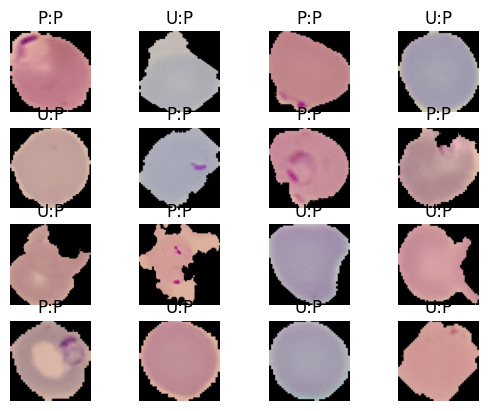

In [37]:
for i , (image, label) in enumerate(test_dataset.take(16)):
  ax = plt.subplot(4, 4, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [38]:
# model.save('malaria_diagnosis.keras')